# 读取 UCI Wine-white 数据集，使用 k-最近邻算法进行缺失值填充，计算自变量（各属性）的填充性能，进行RMSE分析

2023年5月25日

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import random

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [ ]:
Wine-white数据集是UCI机器学习仓库中的一个数据集,用于分类问题。
它包含4898个白葡萄酒样本,每个样本有11个特征属性,以及1个类标签。
该数据集可用于训练和测试分类模型,对不同白葡萄酒进行分类。
11个特征属性包括:
1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash 
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10.Color intensity
11.Hue
1个类标签有:
- class 1
- class 2

In [2]:
# 读取数据集
column_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
wine_white_df = pd.read_csv('winequality-white.csv',header=0, names=column_names, sep=';')
#wine_white_df = pd.read_excel('concrete_data.xls')

In [3]:
wine_white_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...
6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [ ]:
具体流程是:
1. 读取数据到wine_white_df,拷贝原始真实值为wine_white_df_origin
2. 将wine_white_df划分为train_df和test_df,拷贝原始真实值为train_df_origin和test_df_origin
3. 随机在train_df和test_df中产生10%的缺失值
4. 使用KNN在X_train中填充缺失值,并fit knn_imputer模型，调整K值 
5. 使用knn_imputer在X_test_scaled中填充缺失值 
6. 计算填充后X_test_imputed与标准化后真实值X_test_scaled的MSE

In [4]:
wine_white_df_origin = wine_white_df.copy()

In [5]:
wine_white_df_origin

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...
6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]
 df.iloc[:, :-1] 用于取出除最后一列之外的所有特征数据,df.iloc[:, -1] 用于取出最后一列的标签数据。

In [6]:
#1. 将数据集划分为训练集和测试集
#random_state 的取值通常为整数,不同的整数会产生不同的随机结果,而相同的整数会产生相同的随机结果,实现可重复性
#X_train, X_test, y_train, y_test = train_test_split(abalone_df.iloc[:, :-1],abalone_df.iloc[:, -1],test_size=0.2,random_state=1)
train_df, test_df = train_test_split(wine_white_df,test_size=0.2,random_state=42)


In [7]:
train_df_origin = train_df.copy()
test_df_origin = test_df.copy()

In [8]:
# 2. 在训练集中随机产生10%的数据缺失
np.random.seed(0) 
ix = [(row, col) for row in range(train_df.shape[0]) for col in range(train_df.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    train_df.iat[row, col] = np.nan

<AxesSubplot:>

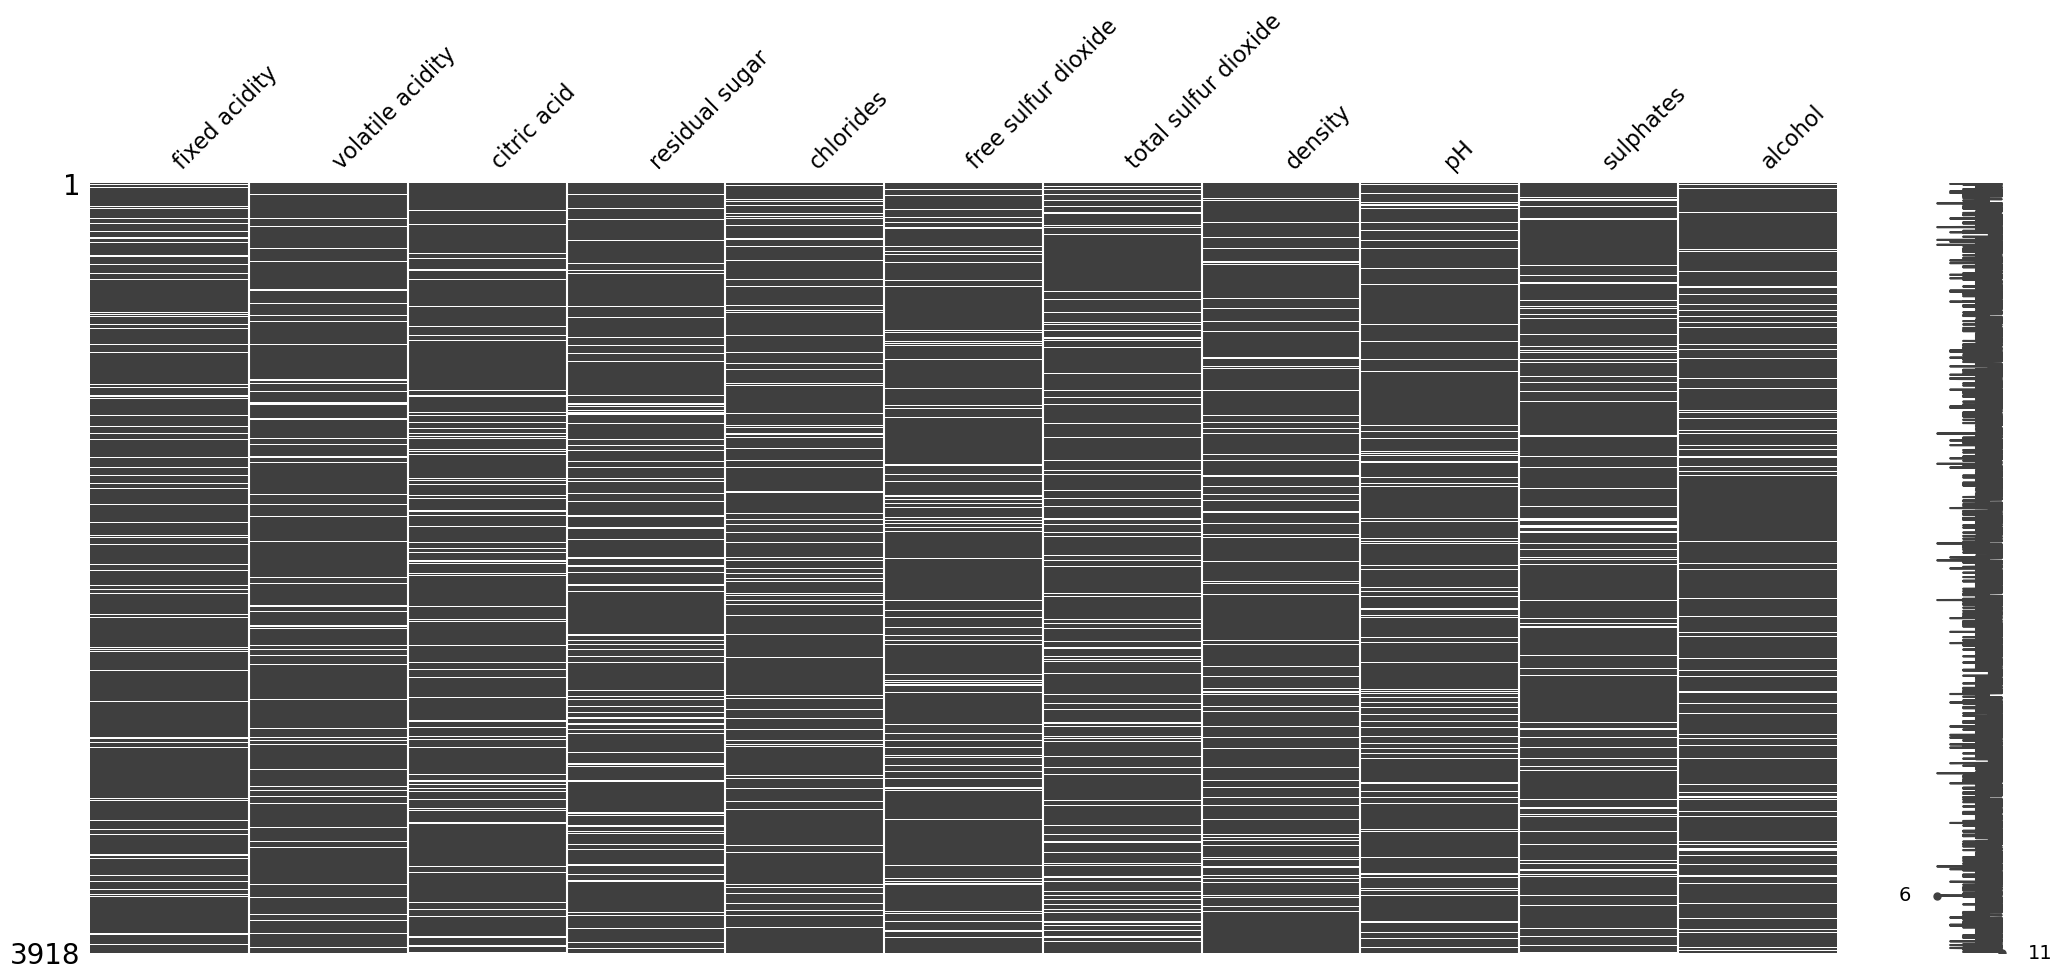

In [9]:
# 可视化缺失值
msno.matrix(train_df)

In [10]:
# 3. 在测试集中随机产生10%的数据缺失
np.random.seed(0) 
ix = [(row, col) for row in range(test_df.shape[0]) for col in range(test_df.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    test_df.iat[row, col] = np.nan

<AxesSubplot:>

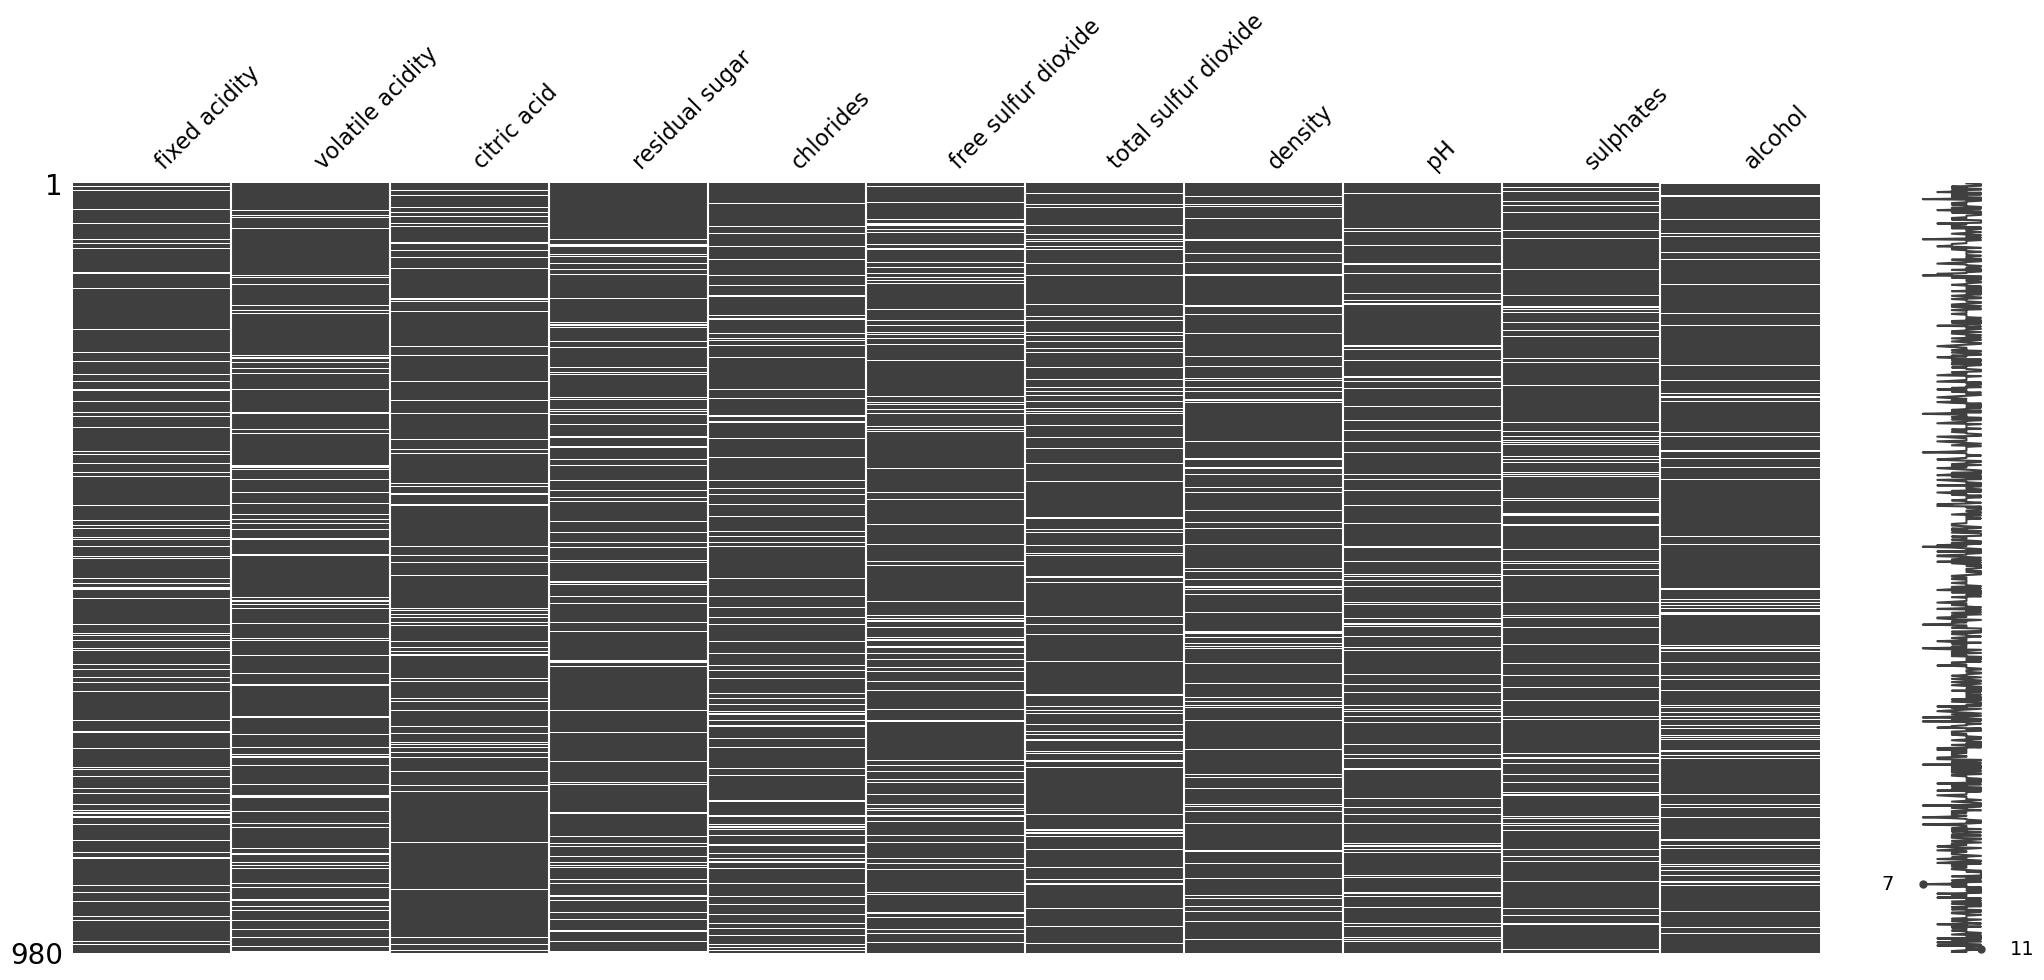

In [11]:
# 可视化缺失值
#msno.matrix(X_test)
#msno.matrix(train_df)
msno.matrix(test_df)

In [12]:
  #计算自变量X的填充性能RMSE 
k_values = []
X_rmse_values=[]
X_rmse_mean=[]
for k in range(1, 20,1):
    imputer = KNNImputer(n_neighbors=k, weights="uniform")
    train_filled = imputer.fit_transform(train_df)
    test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
    train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
    test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
    #mse_train = mean_squared_error(train_df_origin, train_filled)
    mse_test = mean_squared_error(test_df_origin, test_filled, multioutput='raw_values')
    mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
    #print(f'Train MSE: {mse_train}')
    print(f'k=: {k}')
    print(f'Test MSE: {mse_test}')
    print(f'Test mean MSE: {mse_mean}')
    k_values.append(k)
    X_rmse_values.append(mse_test)
    X_rmse_mean.append(mse_mean)    

k=: 1
Test MSE: [1.08665816e-03 1.93795918e-03 2.22575510e+00 6.43173469e-05
 3.58954082e+01 1.45277551e+02 3.48335714e-07 2.56530612e-03
 1.74418367e-03 1.22768991e-01 8.67346939e-02]
Test mean MSE: 16.692328794849733
k=: 2
Test MSE: [1.09230230e-03 1.64630102e-03 1.93442985e+00 5.90558673e-05
 3.35995536e+01 1.40377870e+02 1.92136913e-07 2.24068878e-03
 1.49576531e-03 9.66582341e-02 8.59693878e-02]
Test mean MSE: 16.00918320396462
k=: 3
Test MSE: [1.12559240e-03 1.92315193e-03 1.71466043e+00 5.67570295e-05
 3.34119615e+01 1.40892857e+02 1.58406236e-07 2.42143991e-03
 1.35634921e-03 1.02415785e-01 8.29931973e-02]
Test mean MSE: 16.019251950539736
k=: 4
Test MSE: [1.10340402e-03 1.84625000e-03 1.54441550e+00 5.55674107e-05
 3.27189413e+01 1.31067363e+02 1.39580842e-07 2.28619260e-03
 1.30269770e-03 9.85869650e-02 8.41198980e-02]
Test mean MSE: 15.047274620081975
k=: 5
Test MSE: [1.06662347e-03 1.90781633e-03 1.51692622e+00 5.15559184e-05
 3.05819286e+01 1.37307918e+02 1.44497017e-07 2.

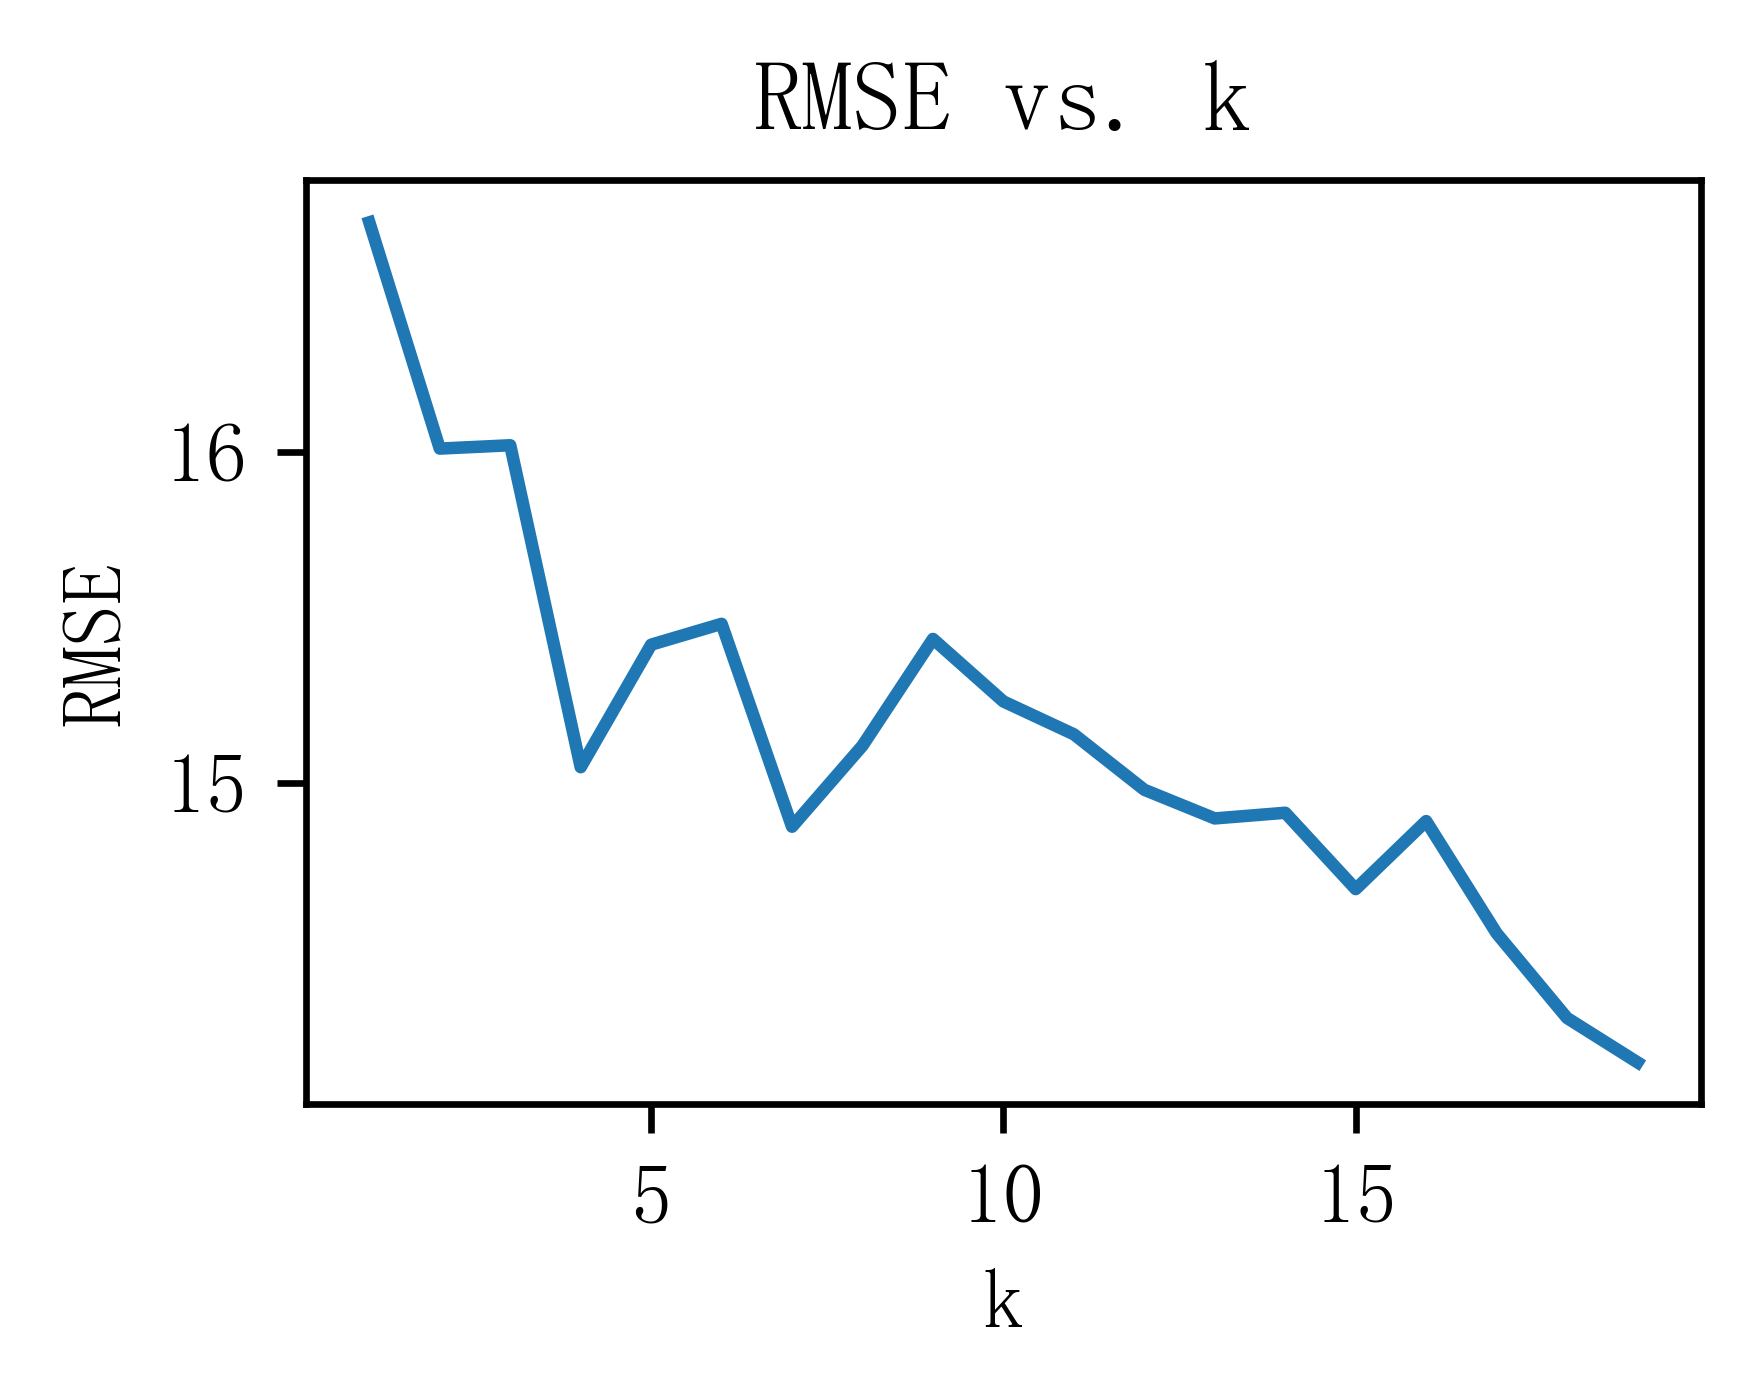

In [13]:
# 设置图像尺寸和分辨率
fig = plt.figure(figsize=(3, 2), dpi=600)

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 设置宋体
plt.rcParams['font.serif'] = ['Times New Roman']  # 设置新罗马
plt.rcParams['font.size'] = 10  # 设置字号为10pt

# 生成 k 值和均方根误差
#k_values = range(1, 21)
#rmse_values = np.random.rand(20) * 10  # 生成随机均方根误差

# 绘制图像
plt.plot(k_values, X_rmse_mean)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('RMSE vs. k')

# 保存图像
plt.savefig('k_rmse_knn_RF.tiff')

In [28]:
# 首先，我们需要将这三个数组堆叠在一起以形成一个新数组
merged_array = np.column_stack((k_values, X_rmse_values, X_rmse_mean))
# 接着，我们将这个数组转换为 Pandas DataFrame
df = pd.DataFrame(merged_array)
# 最后，我们可以将这个 DataFrame 输出到 CSV 文件中
df.to_csv('wine-whiteKNN_K.csv', index=False)  #index=False 表示在输出的 CSV 文件中不包含索引列

In [ ]:
  #计算自变量X的填充性能RMSE 
k_values = []
X_rmse_values=[]
X_rmse_mean=[]

In [13]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=1, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(1)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.10470108005753434
Test MSE: [1.32775120e-01 7.15011962e-05 4.59031100e-05 2.95753589e-05
 1.37340730e-03 1.08141477e-03 1.68038577e-04 2.64355263e-04
 4.54545455e-01]
Test mean MSE: 0.06559497441520468


In [14]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(2)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.07746216708861287
Test MSE: [9.03110048e-02 5.93301435e-05 4.39742823e-05 2.57775120e-05
 7.66144587e-04 8.14282820e-04 1.21531549e-04 1.73424716e-04
 3.53169856e-01]
Test mean MSE: 0.04949836965045189


In [38]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=3, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled)
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

Train MSE: 0.07831306160183431
Test MSE: 0.08158501618155237


In [16]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=3, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(3)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.06809231947077278
Test MSE: [7.84157363e-02 5.03621744e-05 4.15337586e-05 2.19597289e-05
 8.27830841e-04 6.42987440e-04 1.04531632e-04 1.90973551e-04
 4.24774056e-01]
Test mean MSE: 0.05611888575447457


In [17]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=4, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(4)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.06468102314260533
Test MSE: [6.93032297e-02 4.43107057e-05 3.82924641e-05 1.95835825e-05
 7.41743683e-04 4.97771924e-04 9.67078162e-05 1.74965946e-04
 4.39144737e-01]
Test mean MSE: 0.05667348251428761


In [18]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=5, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(5)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.06223128849945127
Test MSE: [6.20574163e-02 4.35968900e-05 3.55227273e-05 1.79760766e-05
 6.29901112e-04 4.17051962e-04 9.27914234e-05 1.75929605e-04
 3.97703349e-01]
Test mean MSE: 0.05124150392743222


In [19]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=6, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(6)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.06107137819057832
Test MSE: [6.02073365e-02 4.59222156e-05 3.38915470e-05 1.76908892e-05
 7.43298013e-04 4.03776922e-04 8.82730263e-05 1.60103602e-04
 3.43135300e-01]
Test mean MSE: 0.04498173256782001


In [20]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=7, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(7)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.0610201237677152
Test MSE: [5.84659701e-02 4.45171370e-05 3.48110536e-05 1.80005615e-05
 8.08591349e-04 3.55845572e-04 8.86931147e-05 1.68222439e-04
 3.22844449e-01]
Test mean MSE: 0.04253656668117805


In [21]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=8, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(8)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.060278759780109915
Test MSE: [5.75097189e-02 4.90435295e-05 3.26153185e-05 1.80136065e-05
 8.61758196e-04 3.41428089e-04 9.14980375e-05 1.58981015e-04
 3.19004187e-01]
Test mean MSE: 0.04200747147721043


In [22]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=9, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(9)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.06047711984082701
Test MSE: [5.75639435e-02 5.02322199e-05 3.33772668e-05 1.84037008e-05
 1.00821365e-03 3.58049349e-04 9.27957314e-05 1.62206373e-04
 3.21430681e-01]
Test mean MSE: 0.04230198921065758


In [23]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=10, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(10)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05943195502569091
Test MSE: [5.66626794e-02 5.06955742e-05 3.50885167e-05 1.80959928e-05
 1.13770302e-03 3.61494489e-04 9.26170514e-05 1.64638068e-04
 3.06339713e-01]
Test mean MSE: 0.040540302783758635


In [24]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=11, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(11)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05902020388354718
Test MSE: [5.64375816e-02 5.06344161e-05 3.54235043e-05 1.84405769e-05
 1.19044108e-03 3.58949734e-04 9.14094814e-05 1.65649900e-04
 3.13911187e-01]
Test mean MSE: 0.04136219077052606


In [25]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=12, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(12)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05791422624352877
Test MSE: [5.44673711e-02 5.58707968e-05 3.66037015e-05 1.89393939e-05
 1.31109519e-03 3.70302887e-04 9.57499772e-05 1.58910968e-04
 3.22559476e-01]
Test mean MSE: 0.042119368925918534


In [26]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=13, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(13)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.057280253865173214
Test MSE: [5.43232072e-02 5.98457716e-05 3.91870275e-05 1.95464455e-05
 1.37215541e-03 3.82704636e-04 9.71766814e-05 1.62134980e-04
 3.26335608e-01]
Test mean MSE: 0.04253239620256599


In [27]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=14, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(14)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05695849612188734
Test MSE: [5.36080461e-02 6.22426094e-05 4.16679890e-05 1.97664413e-05
 1.45128185e-03 3.88200920e-04 9.97003802e-05 1.68221074e-04
 3.24101650e-01]
Test mean MSE: 0.04221564195340218


In [28]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=15, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(15)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05719267807915868
Test MSE: [5.14673046e-02 6.45544923e-05 4.30914407e-05 1.99296917e-05
 1.52989238e-03 3.77393013e-04 1.00697743e-04 1.72758874e-04
 3.16363636e-01]
Test mean MSE: 0.04112658429160022


In [29]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=16, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(16)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05719036525272472
Test MSE: [5.12952303e-02 6.66723516e-05 4.60816014e-05 2.03859758e-05
 1.60313943e-03 3.82563024e-04 1.02018446e-04 1.72471639e-04
 3.13341059e-01]
Test mean MSE: 0.0407810690376732


In [30]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=17, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(17)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.057377748521681565
Test MSE: [5.27474711e-02 6.82107912e-05 4.61621082e-05 2.10298671e-05
 1.63361213e-03 3.48578578e-04 1.02009300e-04 1.75698831e-04
 3.20392046e-01]
Test mean MSE: 0.041726091018429605


In [31]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=18, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(18)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05686287313697528
Test MSE: [5.28050978e-02 7.11462210e-05 4.80469904e-05 2.11126248e-05
 1.62509393e-03 3.47643351e-04 1.02943195e-04 1.77181614e-04
 3.21611584e-01]
Test mean MSE: 0.04186776104028836


In [32]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=19, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(19)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.05678496462499132
Test MSE: [5.33704887e-02 7.29609571e-05 4.93066509e-05 2.11502969e-05
 1.62227688e-03 3.55006251e-04 1.00756653e-04 1.75329100e-04
 3.16637729e-01]
Test mean MSE: 0.04137833380688721


In [33]:
# 4. 使用KNNImputer进行数据填充
imputer = KNNImputer(n_neighbors=20, weights="uniform")
train_filled = imputer.fit_transform(train_df)
test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
#test_df_org = abalone_df_origin.loc[test_df.index] # 获取原始测试集的未缺失数据
mse_train = mean_squared_error(train_df_origin, train_filled)
mse_test = mean_squared_error(test_df_origin, test_filled,multioutput='raw_values')
mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Test mean MSE: {mse_mean}')
k_values.append(20)
X_rmse_values.append(mse_test)
X_rmse_mean.append(mse_mean)

Train MSE: 0.057057323430401756
Test MSE: [5.35885167e-02 7.40106908e-05 4.91404755e-05 2.12204695e-05
 1.69571874e-03 3.62779800e-04 1.03519430e-04 1.81412894e-04
 3.14342105e-01]
Test mean MSE: 0.041157602723036285
